<a href="https://colab.research.google.com/github/marlonrcfranco/soyforecast/blob/master/soyforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soyforecast
By [Marlon Franco]()
/ [GitHub](https://github.com/marlonrcfranco/soyforecast.git)

####Prediction of future soybeans stock prices on the Chicago Stock Exchange (CBOT) using a LSTM model and relating climatic data from the most productive regions of the USA.

![alt text](https://github.com/marlonrcfranco/soyforecast/blob/master/Selection_244.png?raw=true)


## Soybean, CBOT Soybean Futures + ( Global Historical Climatology Network (GHCN) filtered by USDA-NASS-soybeans-production_bushels-2015)

### Soybean, CBOT Soybean Futures
- *https://blog.quandl.com/api-for-commodity-data*
- *http://www.quandl.com/api/v3/datasets/CHRIS/CME_S1/*

### Global Historical Climatology Network (GHCN)
- *https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-ghcn*
- *FTP: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/*


- **TMAX** = Maximum temperature (tenths of degrees C)
- **TMIN** = Minimum temperature (tenths of degrees C)
- **TAVG** = Average temperature (tenths of degrees C)
```
(Note that TAVG from source 'S' corresponds to an average for the period ending at 2400 UTC rather than local midnight )
```
- **PRCP** = Precipitation (tenths of mm)

### USDA-NASS-soybeans-production_bushels-2015
- *https://usda-reports.nautilytics.com/?crop=soybeans&statistic=production_dollars&year=2007*
- *https://www.nass.usda.gov/Data_Visualization/index.php*


****

*Based on the tutorial: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/*


## Imports

In [1]:
%matplotlib inline
import os
from six.moves import urllib

from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import svm
from sklearn.linear_model import LinearRegression
from keras.layers import LSTM, Dense, Input, TimeDistributed, Masking
from keras.models import Model, Sequential, model_from_json
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau



Using TensorFlow backend.


## Defines

In [0]:
DATASETMARLON_URL = "https://raw.githubusercontent.com/marlonrcfranco/soyforecast/master/datasets/DatasetMarlon/datasetMarlon.csv"
DATASETMARLON_PATH = "datasets/DatasetMarlon/"
MODEL_PATH = "model/"
SETTLE_id = 5
TARGET_NAME = 'Settle'

EPOCHS = 100
BATCH_SIZE = 77
TRAIN_SPLIT = 0.87
LOSS_FUNCTION = 'mse' # 'mse': Mean Square Error, 'mae': Mean Absolute Error, 'binary_crossentropy'
LEARNING_RATE = 0.001 #0.001
NEURONS = 128

default = plt.rcParams["figure.figsize"]

## Fetch Data



In [0]:
def fetch_datasetMarlon_data(datasetmarlon_url=DATASETMARLON_URL, datasetmarlon_path=DATASETMARLON_PATH):
    if not os.path.isdir(datasetmarlon_path):
        os.makedirs(datasetmarlon_path)
    csv_path = os.path.join(datasetmarlon_path, "datasetMarlon.csv")
    urllib.request.urlretrieve(datasetmarlon_url, csv_path)

In [0]:
fetch_datasetMarlon_data()

## Convert series to supervised learning


In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


## Load Data


In [0]:
def load_datasetMarlon_data(datasetmarlon_path=DATASETMARLON_PATH):
    csv_path = os.path.join(datasetmarlon_path, "datasetMarlon.csv")
    #print(csv_path)
    return read_csv(csv_path,index_col=['Date','YEAR','MONTH','DAY'])
 

In [7]:
dataset = load_datasetMarlon_data()
values = dataset.values
print(dataset.shape)
dataset.head(1)

(15062, 256)


,,,,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,TX_TMAX_MEAN,TX_TMAX_STD,TX_TMIN_MEAN,TX_TMIN_STD,TX_TAVG_MEAN,TX_TAVG_STD,TX_PRCP_MEAN,TX_PRCP_STD,NC_TMAX_MEAN,NC_TMAX_STD,NC_TMIN_MEAN,NC_TMIN_STD,NC_TAVG_MEAN,NC_TAVG_STD,NC_PRCP_MEAN,NC_PRCP_STD,NE_TMAX_MEAN,NE_TMAX_STD,NE_TMIN_MEAN,NE_TMIN_STD,NE_TAVG_MEAN,NE_TAVG_STD,NE_PRCP_MEAN,NE_PRCP_STD,KS_TMAX_MEAN,KS_TMAX_STD,KS_TMIN_MEAN,KS_TMIN_STD,KS_TAVG_MEAN,KS_TAVG_STD,KS_PRCP_MEAN,KS_PRCP_STD,...,MS_TMAX_MEAN,MS_TMAX_STD,MS_TMIN_MEAN,MS_TMIN_STD,MS_TAVG_MEAN,MS_TAVG_STD,MS_PRCP_MEAN,MS_PRCP_STD,ND_TMAX_MEAN,ND_TMAX_STD,ND_TMIN_MEAN,ND_TMIN_STD,ND_TAVG_MEAN,ND_TAVG_STD,ND_PRCP_MEAN,ND_PRCP_STD,WV_TMAX_MEAN,WV_TMAX_STD,WV_TMIN_MEAN,WV_TMIN_STD,WV_TAVG_MEAN,WV_TAVG_STD,WV_PRCP_MEAN,WV_PRCP_STD,DE_TMAX_MEAN,DE_TMAX_STD,DE_TMIN_MEAN,DE_TMIN_STD,DE_TAVG_MEAN,DE_TAVG_STD,DE_PRCP_MEAN,DE_PRCP_STD,IA_TMAX_MEAN,IA_TMAX_STD,IA_TMIN_MEAN,IA_TMIN_STD,IA_TAVG_MEAN,IA_TAVG_STD,IA_PRCP_MEAN,IA_PRCP_STD
Date,YEAR,MONTH,DAY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-04-22,2019,4,22,881.5,883.25,876.25,876.75,3.5,877.0,62527.0,205572.0,72.62779,566.42426,44.583332,354.48105,18.318048,317.19855,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot heatmap for correlation

In [0]:
# This can take some time

#corr = dataset.corr()
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)

## Plot columns from CBOT dataset

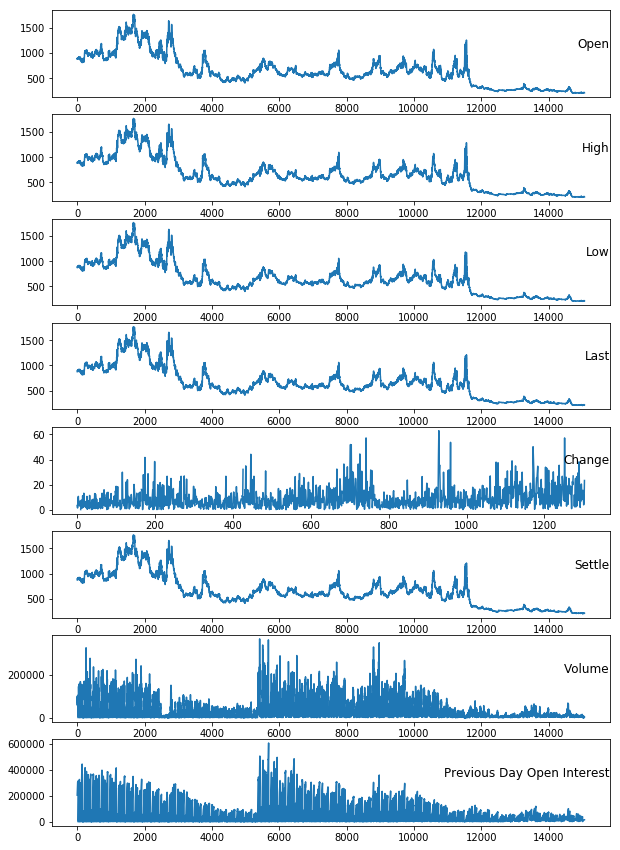

In [9]:
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(10,15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

## Plot columns from GHCN dataset (filtered by the state of Texas)



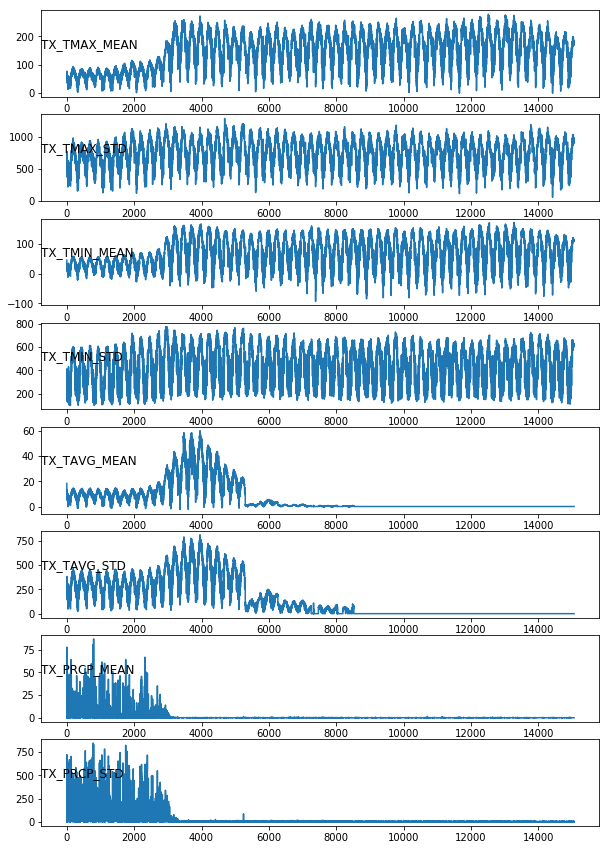

In [10]:
# specify columns to plot
groups = [8,9,10,11,12,13,14,15]
i = 1
# plot each column
plt.figure(figsize=(10,15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='left')
	i += 1
plt.show()

## Integer encode direction

In [0]:
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

## Ensure all data is float


In [0]:
values = values.astype('float32')

## Normalize features

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## Specify the number of lag hours

In [0]:
n_days = 7 # A month before
n_features = 256

## Frame as supervised learning

In [15]:
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)
reframed.head()


(10991, 2048)


,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),var11(t-7),var12(t-7),var13(t-7),var14(t-7),var15(t-7),var16(t-7),var17(t-7),var18(t-7),var19(t-7),var20(t-7),var21(t-7),var22(t-7),var23(t-7),var24(t-7),var25(t-7),var26(t-7),var27(t-7),var28(t-7),var29(t-7),var30(t-7),var31(t-7),var32(t-7),var33(t-7),var34(t-7),var35(t-7),var36(t-7),var37(t-7),var38(t-7),var39(t-7),var40(t-7),...,var217(t),var218(t),var219(t),var220(t),var221(t),var222(t),var223(t),var224(t),var225(t),var226(t),var227(t),var228(t),var229(t),var230(t),var231(t),var232(t),var233(t),var234(t),var235(t),var236(t),var237(t),var238(t),var239(t),var240(t),var241(t),var242(t),var243(t),var244(t),var245(t),var246(t),var247(t),var248(t),var249(t),var250(t),var251(t),var252(t),var253(t),var254(t),var255(t),var256(t)
8,0.430163,0.431369,0.429128,0.431731,0.000359,0.431572,0.171927,0.353242,0.201763,0.431541,0.456176,0.300841,0.169949,0.328450,0.896115,0.851300,0.229714,0.547190,0.458680,0.379904,0.277167,0.401238,0.000586,0.015170,0.404762,0.356728,0.569178,0.090203,0.401204,0.168394,0.019776,0.150741,0.363888,0.365142,0.557153,0.075924,0.360311,0.185684,0.062892,0.409582,...,0.371910,0.524527,0.588045,0.493318,0.460136,0.560212,0.317801,0.402935,0.487779,0.293198,0.585826,0.106894,0.511277,0.111702,0.000727,0.004247,0.532091,0.444306,0.648556,0.320789,0.617937,0.500162,0.244014,0.333859,0.250646,0.281392,0.446682,0.271970,0.247504,0.203999,0.055373,0.176851,0.512180,0.490143,0.616917,0.128333,0.470187,0.265425,0.000550,0.006923
9,0.435911,0.436790,0.430404,0.430614,0.002942,0.430614,0.242938,0.361835,0.230660,0.479189,0.494639,0.463921,0.226693,0.421765,0.006275,0.031552,0.214966,0.502637,0.431140,0.209312,0.265397,0.359200,0.000099,0.001789,0.423053,0.431792,0.582858,0.157163,0.432913,0.283714,0.013212,0.098600,0.396977,0.440580,0.590694,0.143208,0.396221,0.309503,0.000522,0.024596,...,0.355455,0.528713,0.596836,0.557724,0.453071,0.551214,0.820306,0.644928,0.544200,0.412315,0.642775,0.096670,0.558766,0.337722,0.007512,0.018592,0.572613,0.546953,0.606333,0.295206,0.634065,0.533847,0.324920,0.375600,0.253182,0.353047,0.445714,0.250457,0.246859,0.204921,0.017327,0.068066,0.502198,0.469681,0.620976,0.137802,0.477043,0.300327,0.036553,0.085632
10,0.442617,0.442212,0.435350,0.436359,0.003516,0.436359,0.251458,0.365132,0.242662,0.496247,0.468674,0.358339,0.222838,0.404125,0.000110,0.001702,0.190328,0.414317,0.415874,0.125339,0.238111,0.262694,0.002535,0.016891,0.453810,0.505408,0.574211,0.109289,0.443341,0.286492,0.000728,0.006846,0.395761,0.444830,0.570300,0.113684,0.396403,0.309299,0.000000,0.000000,...,0.302206,0.446837,0.550406,0.448382,0.412175,0.482795,0.605323,0.635286,0.483573,0.311606,0.614646,0.060367,0.531559,0.190482,0.004040,0.011751,0.513266,0.440836,0.539564,0.174681,0.607398,0.449416,0.101524,0.159672,0.244949,0.153596,0.441872,0.119184,0.238309,0.096205,0.001507,0.026990,0.425961,0.281899,0.615545,0.133919,0.452272,0.191550,0.024786,0.053430
11,0.440542,0.444126,0.440775,0.443221,0.001148,0.443221,0.246762,0.382209,0.219540,0.455343,0.418607,0.180602,0.205872,0.364898,0.000488,0.003224,0.195655,0.436074,0.447489,0.354754,0.239016,0.299704,0.209493,0.329362,0.424834,0.395336,0.552077,0.108095,0.437964,0.277871,0.000249,0.003263,0.363192,0.358510,0.531583,0.050569,0.383882,0.260925,0.000385,0.016370,...,0.308864,0.406368,0.482938,0.349272,0.389979,0.398535,0.051966,0.127961,0.478306,0.342071,0.583938,0.132277,0.532925,0.222117,0.001670,0.006387,0.504641,0.396672,0.482767,0.095158,0.572430,0.422047,0.000000,0.000000,0.249714,0.256804,0.441274,0.099619,0.243130,0.150464,0.000000,0.000000,0.420924,0.232492,0.589131,0.153001,0.443218,0.145499,0.070249,0.187655
12,0.440542,0.441893,0.440137,0.440508,0.669824,0.440987,0.187976,0.398964,0.202366,0.434235,0.425404,0.267301,0.176228,0.318783,0.004867,0.024482,0.206077,0.475031,0.462841,0.424089,0.261478,0.368925,0.063191,0.131305,0.325204,0.083416,0.515858,0.168162,0.3

## Drop columns we don't want to predict

In [16]:
cols = [reframed.columns.get_loc(col) for col in reframed.columns if reframed.columns.get_loc(col)>=n_days*n_features and reframed.columns.get_loc(col)!=(n_days*n_features+SETTLE_id)]
reframed.drop(reframed.columns[cols], axis=1, inplace=True)
print(reframed.shape)
reframed.head()

(10991, 1793)


,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),var11(t-7),var12(t-7),var13(t-7),var14(t-7),var15(t-7),var16(t-7),var17(t-7),var18(t-7),var19(t-7),var20(t-7),var21(t-7),var22(t-7),var23(t-7),var24(t-7),var25(t-7),var26(t-7),var27(t-7),var28(t-7),var29(t-7),var30(t-7),var31(t-7),var32(t-7),var33(t-7),var34(t-7),var35(t-7),var36(t-7),var37(t-7),var38(t-7),var39(t-7),var40(t-7),...,var218(t-1),var219(t-1),var220(t-1),var221(t-1),var222(t-1),var223(t-1),var224(t-1),var225(t-1),var226(t-1),var227(t-1),var228(t-1),var229(t-1),var230(t-1),var231(t-1),var232(t-1),var233(t-1),var234(t-1),var235(t-1),var236(t-1),var237(t-1),var238(t-1),var239(t-1),var240(t-1),var241(t-1),var242(t-1),var243(t-1),var244(t-1),var245(t-1),var246(t-1),var247(t-1),var248(t-1),var249(t-1),var250(t-1),var251(t-1),var252(t-1),var253(t-1),var254(t-1),var255(t-1),var256(t-1),var6(t)
8,0.430163,0.431369,0.429128,0.431731,0.000359,0.431572,0.171927,0.353242,0.201763,0.431541,0.456176,0.300841,0.169949,0.328450,0.896115,0.851300,0.229714,0.547190,0.458680,0.379904,0.277167,0.401238,0.000586,0.015170,0.404762,0.356728,0.569178,0.090203,0.401204,0.168394,0.019776,0.150741,0.363888,0.365142,0.557153,0.075924,0.360311,0.185684,0.062892,0.409582,...,0.577949,0.554269,0.395771,0.503953,0.607306,0.040479,0.193762,0.415522,0.139545,0.553601,0.140833,0.489100,0.095630,0.014085,0.083460,0.558218,0.494523,0.533181,0.096990,0.608214,0.463769,0.001140,0.028621,0.250913,0.275345,0.442415,0.128911,0.245567,0.173112,0.000214,0.004264,0.462003,0.397564,0.608633,0.127016,0.442540,0.142258,0.037625,0.254125,0.443221
9,0.435911,0.436790,0.430404,0.430614,0.002942,0.430614,0.242938,0.361835,0.230660,0.479189,0.494639,0.463921,0.226693,0.421765,0.006275,0.031552,0.214966,0.502637,0.431140,0.209312,0.265397,0.359200,0.000099,0.001789,0.423053,0.431792,0.582858,0.157163,0.432913,0.283714,0.013212,0.098600,0.396977,0.440580,0.590694,0.143208,0.396221,0.309503,0.000522,0.024596,...,0.524527,0.588045,0.493318,0.460136,0.560212,0.317801,0.402935,0.487779,0.293198,0.585826,0.106894,0.511277,0.111702,0.000727,0.004247,0.532091,0.444306,0.648556,0.320789,0.617937,0.500162,0.244014,0.333859,0.250646,0.281392,0.446682,0.271970,0.247504,0.203999,0.055373,0.176851,0.512180,0.490143,0.616917,0.128333,0.470187,0.265425,0.000550,0.006923,0.443221
10,0.442617,0.442212,0.435350,0.436359,0.003516,0.436359,0.251458,0.365132,0.242662,0.496247,0.468674,0.358339,0.222838,0.404125,0.000110,0.001702,0.190328,0.414317,0.415874,0.125339,0.238111,0.262694,0.002535,0.016891,0.453810,0.505408,0.574211,0.109289,0.443341,0.286492,0.000728,0.006846,0.395761,0.444830,0.570300,0.113684,0.396403,0.309299,0.000000,0.000000,...,0.528713,0.596836,0.557724,0.453071,0.551214,0.820306,0.644928,0.544200,0.412315,0.642775,0.096670,0.558766,0.337722,0.007512,0.018592,0.572613,0.546953,0.606333,0.295206,0.634065,0.533847,0.324920,0.375600,0.253182,0.353047,0.445714,0.250457,0.246859,0.204921,0.017327,0.068066,0.502198,0.469681,0.620976,0.137802,0.477043,0.300327,0.036553,0.085632,0.443381
11,0.440542,0.444126,0.440775,0.443221,0.001148,0.443221,0.246762,0.382209,0.219540,0.455343,0.418607,0.180602,0.205872,0.364898,0.000488,0.003224,0.195655,0.436074,0.447489,0.354754,0.239016,0.299704,0.209493,0.329362,0.424834,0.395336,0.552077,0.108095,0.437964,0.277871,0.000249,0.003263,0.363192,0.358510,0.531583,0.050569,0.383882,0.260925,0.000385,0.016370,...,0.446837,0.550406,0.448382,0.412175,0.482795,0.605323,0.635286,0.483573,0.311606,0.614646,0.060367,0.531559,0.190482,0.004040,0.011751,0.513266,0.440836,0.539564,0.174681,0.607398,0.449416,0.101524,0.159672,0.244949,0.153596,0.441872,0.119184,0.238309,0.096205,0.001507,0.026990,0.425961,0.281899,0.615545,0.133919,0.452272,0.191550,0.024786,0.053430,0.448168
12,0.440542,0.441893,0.440137,0.440508,0.669824,0.440987,0.187976,0.398964,0.202366,0.434235,0.425404,0.267301,0.176228,0.318783,0.004867,0.024482,0.206077,0.475031,0.462841,0.424089

## Split into train and test sets

In [0]:
train_split = TRAIN_SPLIT #0.87

In [18]:
values = reframed.values
num_data = len(values)
num_data

10991

In [19]:
num_train = int(train_split * num_data)
num_train

9562

In [20]:
num_test = num_data - num_train
num_test

1429

In [21]:
train = values[:num_train, :]
test = values[num_train:, :]
len(train) + len(test)

10991

## Split into input and outputs

In [22]:
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
svm_train_y = train_y.copy()
svm_test_y = test_y.copy()

print(train_X.shape, len(train_X), train_y.shape)

(9562, 1792) 9562 (9562,)


## Reshape input to be 3D [samples, timesteps, features]

In [23]:
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
svm_train_X = train_X.copy()
svm_test_X = test_X.copy()
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(9562, 7, 256) (9562,) (1429, 7, 256) (1429,)


## Design network

In [24]:
model = Sequential()
model.add(LSTM(NEURONS, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, name='lstm1'))
model.add(LSTM(NEURONS, name='lstm2'))
model.add(Dense(1, activation='linear', name='output'))
optimizer = Adam(lr=LEARNING_RATE)
model.compile(loss=LOSS_FUNCTION, optimizer=optimizer)
model.summary()

W0624 02:32:13.785245 140686416684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 02:32:13.802486 140686416684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 02:32:13.805573 140686416684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 02:32:14.416566 140686416684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 7, 128)            197120    
_________________________________________________________________
lstm2 (LSTM)                 (None, 128)               131584    
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 328,833
Trainable params: 328,833
Non-trainable params: 0
_________________________________________________________________


In [0]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Fit network


In [26]:
%%time
history = model.fit(
    train_X, 
    train_y, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(test_X, test_y), 
    verbose=1, 
    shuffle=False)

W0624 02:32:14.789334 140686416684928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0624 02:32:15.968796 140686416684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0624 02:32:16.082584 140686416684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 9562 samples, validate on 1429 samples
Epoch 1/100
9562/9562 [==============================] - 6s 631us/step - loss: 0.0213 - val_loss: 9.9533e-04
Epoch 2/100
9562/9562 [==============================] - 4s 398us/step - loss: 0.0213 - val_loss: 0.0066
Epoch 3/100
9562/9562 [==============================] - 4s 392us/step - loss: 0.0197 - val_loss: 0.0099
Epoch 4/100
9562/9562 [==============================] - 4s 395us/step - loss: 0.0196 - val_loss: 0.0131
Epoch 5/100
9562/9562 [==============================] - 4s 396us/step - loss: 0.0204 - val_loss: 0.0093
Epoch 6/100
9562/9562 [==============================] - 4s 398us/step - loss: 0.0194 - val_loss: 0.0104
Epoch 7/100
9562/9562 [==============================] - 4s 393us/step - loss: 0.0199 - val_loss: 0.0096
Epoch 8/100
9562/9562 [==============================] - 4s 394us/step - loss: 0.0173 - val_loss: 0.0034
Epoch 9/100
9562/9562 [==============================] - 4s 398us/step - loss: 0.0148 - val_loss: 0.0025
Epo

## Plot history

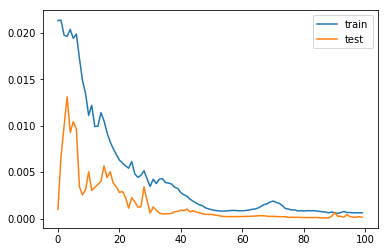

In [27]:
plt.figure(figsize=default)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Make a prediction

In [0]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

## Invert scaling for forecast

In [0]:
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

## Invert scaling for actual

In [0]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

## Calculate RMSE

In [31]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18.789


## Plot prediction

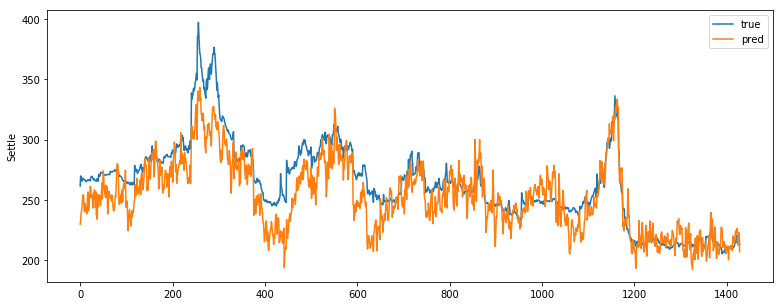

In [32]:
  # Get the output-signal predicted by the model.
  signal_pred = inv_yhat

  # Get the true output-signal from the data-set.
  signal_true = inv_y

  # Make the plotting-canvas bigger.
  plt.figure(figsize=(13,5))

  # Plot and compare the two signals.
  plt.plot(signal_true, label='true')
  plt.plot(signal_pred, label='pred')

  # Plot labels etc.
  plt.ylabel(TARGET_NAME)
  plt.legend()
  plt.show()

# Compare results with a SVM model

## Creating a SVM  for regression (SVR)

In [0]:
clf = svm.SVR() #svm.SVR(kernel='rbf') #svm.SVR()

## Training

In [0]:
svm_train_X_1 = svm_train_X.reshape((svm_train_X.shape[0], n_days*n_features))
svm_test_X_1 = svm_test_X.reshape((svm_test_X.shape[0], n_days*n_features))

In [35]:
clf.fit(svm_train_X_1, svm_train_y) #train

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

## Make a prediction

In [0]:
svm_yhat = clf.predict(svm_test_X_1)

## Invert scaling for forecast (return values to original range)

In [0]:
svm_inv_yhat = concatenate((svm_yhat.reshape(-1,1), svm_test_X_1[:,-(n_features-1):]), axis=1)
svm_inv_yhat = scaler.inverse_transform(svm_inv_yhat)
svm_inv_yhat = svm_inv_yhat[:,0]

## Invert scaling for actual (return values to original range)

In [0]:
svm_test_y = svm_test_y.reshape((len(svm_test_y), 1))
svm_inv_y = concatenate((svm_test_y, svm_test_X_1[:, -(n_features-1):]), axis=1)
svm_inv_y = scaler.inverse_transform(svm_inv_y)
svm_inv_y = svm_inv_y[:,0]

## Calculate RMSE

In [39]:
svm_rmse = sqrt(mean_squared_error(svm_inv_y, svm_inv_yhat))
print('Test RMSE: %.3f' % svm_rmse)

Test RMSE: 178.381


## Plot prediction

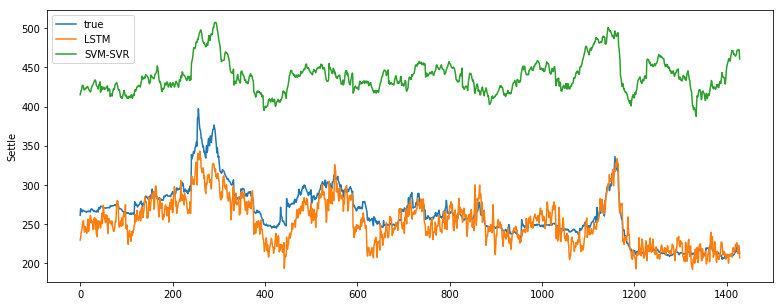

In [40]:
    # Make the plotting-canvas bigger.
  plt.figure(figsize=(13,5))

  # Plot and compare the two signals.
  plt.plot(svm_inv_y, label='true')
  plt.plot(inv_yhat, label='LSTM')
  plt.plot(svm_inv_yhat, label='SVM-SVR')

  # Plot labels etc.
  plt.ylabel(TARGET_NAME)
  plt.legend()
  plt.show()

# Extra

## Save model to JSON

In [41]:
# serialize model to JSON
model_json = model.to_json()
if not os.path.isdir(MODEL_PATH):
    os.makedirs(MODEL_PATH)
with open(MODEL_PATH+"model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(MODEL_PATH+"model.h5")
print("Saved model to disk")

Saved model to disk


## Load json and create model

In [42]:
# load json and create model
json_file = open(MODEL_PATH+'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(MODEL_PATH+"model.h5")
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 7, 128)            197120    
_________________________________________________________________
lstm2 (LSTM)                 (None, 128)               131584    
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 328,833
Trainable params: 328,833
Non-trainable params: 0
_________________________________________________________________


# License (MIT)

Copyright (c) 2018 by [Marlon Franco]()

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.